In [1]:
import Pkg; Pkg.add("Rotations")

    Updating registry at `C:\Users\g.kirillov\.julia\registries\General.toml`
   Resolving package versions...
┌ Warning: The active manifest file at `C:\Users\g.kirillov\DDP\Manifest.toml` has an old format that is being maintained.
│ To update to the new format run `Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
└ @ Pkg.Types C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.7\Pkg\src\manifest.jl:287
  No Changes to `C:\Users\g.kirillov\DDP\Project.toml`
  No Changes to `C:\Users\g.kirillov\DDP\Manifest.toml`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ C:\Users\g.kirillov\DDP\Manifest.toml:0


In [2]:
import Pkg; Pkg.activate("."); Pkg.instantiate()

  Activating project at `C:\Users\g.kirillov\DDP`


In [3]:
import Pkg; Pkg.precompile()

In [4]:
using Pkg
Pkg.build("MeshCat")

    Building WebIO ──→ `C:\Users\g.kirillov\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\c9529be473e97fa0b3b2642cdafcd0896b4c9494\build.log`
    Building Blink ──→ `C:\Users\g.kirillov\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\08d0b679fd7caa49e2bca9214b131289e19808c0\build.log`
    Building MeshCat → `C:\Users\g.kirillov\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\ca4a1e45f5d2a2148c599804a6619da7708ede69\build.log`


In [5]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using RobotZoo
using RobotDynamics
import RobotDynamics as RD
using MatrixCalculus
using JLD2
using StaticArrays
using Rotations

In [6]:
#Acrobot Dynamics
a = RobotZoo.Quadrotor()
h = 0.05

0.05

In [7]:
dynamics(a, SVector{13}(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.), 
            SVector{4}(0.0, 0.0, 0.0, 0.0))

13-element SVector{13, Float64} with indices SOneTo(13):
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -9.81
  0.0
  0.0
  0.0

In [8]:
?RobotZoo.Quadrotor

```
Quadrotor{R}
```

A standard quadrotor model, with simple aerodynamic forces. The orientation is represent by a general rotation `R`. The body z-axis point is vertical, so positive controls cause acceleration in the positive z direction.

# Constructor

```
Quadrotor(; kwargs...)
Quadrotor{R}(; kwargs...)
```

where `R <: Rotation{3}` and defaults to `UnitQuaternion{Float64}` if omitted. The keyword arguments are

  * `mass` - mass of the quadrotor, in kg (default = 0.5)
  * `J` - inertia of the quadrotor, in kg⋅m² (default = `Diagonal([0.0023, 0.0023, 0.004])`)
  * `gravity` - gravity vector, in kg/m² (default = [0,0,-9.81])
  * `motor_dist` - distane between the motors, in m (default = 0.1750)
  * `km` - motor torque constant (default = 0.0245)
  * `kf` - motor force constant (default = 1.0)


In [9]:
?AbstractModel

search: AbstractModel AbstractMatch AbstractMatrix AbstractVecOrMat



AbstractModel

Abstraction of a model of a dynamical system of the form ẋ = f(x,u), where x is the n-dimensional state vector and u is the m-dimensional control vector.

Any inherited type must define the following interface: ẋ = dynamics(model, x, u) n,m = size(model)


In [10]:
?RigidBody

search: RigidBody



```
RigidBody{R<:Rotation} <: LieGroupModel
```

Abstraction of a dynamical system with free-body dynamics, with a 12 or 13-dimensional state vector: `[p; q; v; ω]` where `p` is the 3D position, `q` is the 3 or 4-dimension attitude representation, `v` is the 3D linear velocity, and `ω` is the 3D angular velocity.

# Interface

Any single-body system can leverage the `RigidBody` type by inheriting from it and defining the following interface:

```julia
forces(::MyRigidBody, x, u)  # return the forces in the world frame
moments(::MyRigidBody, x, u) # return the moments in the body frame
inertia(::MyRigidBody, x, u) # return the 3x3 inertia matrix
mass(::MyRigidBody, x, u)  # return the mass as a real scalar
```

Instead of defining `forces` and `moments` you can define the higher-level `wrenches` function 	wrenches(model::MyRigidbody, z::AbstractKnotPoint) 	wrenches(model::MyRigidbody, x, u)

# Rotation Parameterization

A `RigidBody` model must specify the rotational representation being used. Any `Rotations.Rotation{3}` can be used, but we suggest one of the following:

  * `UnitQuaternion`
  * `MRP`
  * `RodriguesParam`


In [11]:
?QuatRotation

search: QuatRotation



```
QuatRotation{T} <: Rotation
```

4-parameter attitute representation that is singularity-free. Quaternions with unit norm represent a double-cover of SO(3). The `QuatRotation` does NOT strictly enforce the unit norm constraint, but certain methods will assume you have a unit quaternion. Follows the Hamilton convention for quaternions.

# Constructors

```julia
QuatRotation(w,x,y,z)
QuatRotation(q::AbstractVector)
```

where `w` is the scalar (real) part, `x`, `y`, and `z` are the vector (imaginary) part, and `q = [w,x,y,z]`.


In [12]:
?RD.dynamics

```
ẋ = dynamics(model, z::AbstractKnotPoint)
ẋ = dynamics(model, x, u, [t=0])
```

Compute the continuous dynamics of a forced dynamical given the states `x`, controls `u` and time `t` (optional).


In [13]:
function quadrotor_jacobian(x, u)
    x_static = SVector{13, Float64}(x)
    u_static = SVector{4, Float64}(u)
    return ForwardDiff.jacobian(dx->dynamics(a, dx,u_static),x_static)
end

quadrotor_jacobian (generic function with 1 method)

In [14]:
function quadrotor_input_jacobian(x,u)
    x_static = SVector{13, Float64}(x)
    u_static = SVector{4, Float64}(u)
    return ForwardDiff.jacobian(du->dynamics(a, x_static,du),u_static)
end

quadrotor_input_jacobian (generic function with 1 method)

In [15]:
function dfdx(x,u)
    return I(13) + quadrotor_jacobian(x,u) .* h
end

function dfdu(x,u)
    return quadrotor_input_jacobian(x,u) .* h
end

dfdu (generic function with 1 method)

In [16]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    x = SVector{13}(x)
    u = SVector{4}(u)
    # xn = Array(x + h * dynamics(a, x, u))
    xn = Array(dfdx(x,u) * x + dfdu(x,u) * u) # ZOH
    xn[4:7] .= xn[4:7]/norm(xn[4:7])
    return xn
end

dynamics_rk4 (generic function with 1 method)

In [17]:
Nx = 13   # number of state
Nu = 4     # number of controls
Tfinal = 2.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [18]:
# Cost weights
Q = Diagonal([1.0 * ones(7); 0.1 * ones(6)]);
R = Array(0.001*I(Nu));
Qn = Array(1000.0*I(Nx));

In [19]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5(u'*R*u)
end

stage_cost (generic function with 1 method)

In [20]:
function terminal_cost(x)
    return 0.5*(x-xgoal)'*Qn*(x-xgoal)
end
# посмотреть как делают остальные

terminal_cost (generic function with 1 method)

In [21]:
function cost(xtraj,utraj)
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[:,k])
        # display(J)
    end
    J += terminal_cost(xtraj[:,Nt])
    
    return J
end

cost (generic function with 1 method)

In [22]:
function backward_pass!(p,P,d,K)
    
    ΔJ = 0.0
    p[:,Nt] .= Qn*(xtraj[:,Nt]-xgoal)
    P[:,:,Nt] .= Qn
    
    for k = (Nt-1):-1:1
        #Calculate derivatives
        q = Q*(xtraj[:,k]-xgoal)
        r = R*utraj[:, k]
    
        A = dfdx(xtraj[:,k], utraj[:,k]) #ForwardDiff.jacobian(dx->dynamics_rk4(dx,utraj[k]),xtraj[:,k])
        B = dfdu(xtraj[:,k], utraj[:,k]) #ForwardDiff.derivative(du->dynamics_rk4(xtraj[:,k],du),utraj[k])
        
        # Ax = dAdx(xtraj[:,k], utraj[:,k])
        # Bx = dBdx(xtraj[:,k], utraj[:,k])
        # Au = dAdu(xtraj[:,k], utraj[:,k])
        # Bu = dBdu(xtraj[:,k], utraj[:,k])
    
        gx = q + A'*p[:,k+1]
        gu = r + B'*p[:,k+1]
    
        #iLQR (Gauss-Newton) version
        Gxx = Q + A'*P[:,:,k+1]*A
        Guu = R + B'*P[:,:,k+1]*B
        Gxu = A'*P[:,:,k+1]*B
        Gux = B'*P[:,:,k+1]*A
        
        #DDP (full Newton) version
        # Gxx = Q + A'*P[:,:,k+1]*A + kron(p[:,k+1]',I(Nx))*comm(Nx,Nx)*Ax
        # Guu = R + B'*P[:,:,k+1]*B + (kron(p[:,k+1]',I(Nu))*comm(Nx,Nu)*Bu)[1]
        # Gxu = A'*P[:,:,k+1]*B + kron(p[:,k+1]',I(Nx))*comm(Nx,Nx)*Au
        # Gux = B'*P[:,:,k+1]*A + kron(p[:,k+1]',I(Nu))*comm(Nx,Nu)*Bx
        
        β = 0.1
        while !isposdef(Symmetric([Gxx Gxu; Gux Guu]))
            Gxx += A'*β*I*A
            Guu += B'*β*I*B
            Gxu += A'*β*I*B
            Gux += B'*β*I*A
            β = 2*β
            # display("regularizing G")
            if β == Inf
                return NaN
            end
        end

        try
            _ = Guu \ ones(size(Guu,1))
        catch e
            if isa(e, SingularException)
                return NaN
            end
        end

        d[:,k] .= Guu\gu
        K[:,:,k] .= Guu\Gux
    
        p[:,k] .= gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[:,k] - Gxu*d[:,k]
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
    
        ΔJ += gu'*d[:,k]
    end
    
    return ΔJ
end

backward_pass! (generic function with 1 method)

In [23]:
#Initial guess
m=a.mass
g=9.81
uhover = SVector{4}((m*g/4)*ones(4))
x0 = ([0.0; 0.0; 0; 1; 0; 0; 0; 0; 0; 0; 0; 0; 0])
xgoal = SVector{13}([0.0; 0.0; 0.0; 0.965926; 0.258819; 0.0; 0.0; 0; 0; 0; 0; 0; 0])
xtraj = kron(ones(1,Nt), x0)
utraj = zeros(Nu, Nt-1) .+ uhover
#f = jldopen("guess.jld2", "r")
#utraj = f["utraj"];

In [24]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[:,k])
end
J = cost(xtraj,utraj)

3.393425945850969e6

In [25]:
#DDP Algorithm
p = ones(Nx,Nt)
P = zeros(Nx,Nx,Nt)
d = ones(Nu,Nt-1)
K = zeros(Nu,Nx,Nt-1)
ΔJ = 1.0

xn = zeros(Nx,Nt)
un = zeros(Nu,Nt-1)

gx = zeros(Nx)
gu = zeros(Nu)
Gxx = zeros(Nx,Nx)
Guu = zeros(Nu)
Gxu = zeros(Nx)
Gux = zeros(Nx)

iter = 0
Jp = 0
while abs(Jp-J) >  5 * 1e-5
    iter += 1    
    
    #Backward Pass
    ΔJ = backward_pass!(p,P,d,K)
    if isnan(ΔJ)
        stop = true
        break
    end
    
    #Forward rollout with line search
    xn[:,1] = xtraj[:,1]
    α = 1.0
    
    # display(K[:,:,1] * (xn[:,1]-xtraj[:,1]))
    # display(utraj[:,1] - α*d[:,1] - K[:,:,1] * (xn[:,1]-xtraj[:,1]))
    
    for k = 1:(Nt-1)
        un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
    end
    Jn = cost(xn,un)
    # display(Jn)
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α = 0.5*α
        for k = 1:(Nt-1)
            un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
        end
        Jn = cost(xn,un)
        # display(Jn)
    end
    Jp = J
    J = Jn
    xtraj .= xn
    utraj .= un
    display(J)
    # display(iter)
    # display(α)
    # display(maximum(abs.(d[:])))
    # display(xtraj[:, Nt])
end

35.92010508346336

35.437122363249394

27.11898744882741

20.209057419572353

9.737057637003712

2.756038910121956

2.626648524350149

2.604838312031748

2.5877729730625205

2.5877729730625165

In [26]:
iter

10

In [27]:
QuatRotation(RotXYZ(1,2,3))

3×3 QuatRotation{Float64} with indices SOneTo(3)×SOneTo(3)(QuaternionF64(0.368871, -0.754934, 0.206149, -0.501509)):
  0.411982   0.0587266   0.909297
 -0.681243  -0.642873    0.350175
  0.605127  -0.763718   -0.224845

In [28]:
J

2.5877729730625165

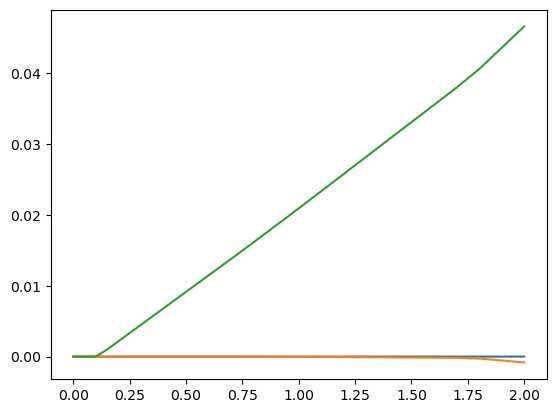

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000000F285C0>

In [29]:
plot(thist,xtraj[1,:])
plot(thist,xtraj[2,:])
plot(thist,xtraj[3,:])

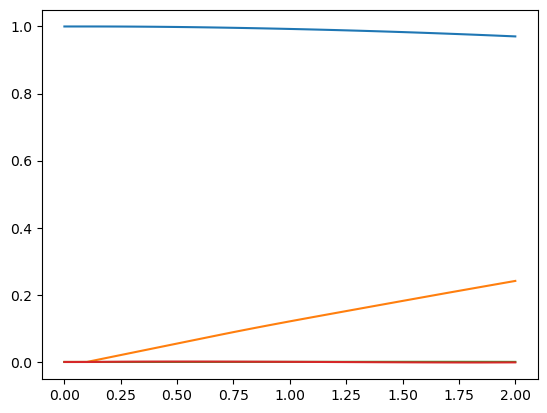

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001007CB0>

In [30]:
plot(thist,xtraj[4,:])
plot(thist,xtraj[5,:])
plot(thist,xtraj[6,:])
plot(thist,xtraj[7,:])

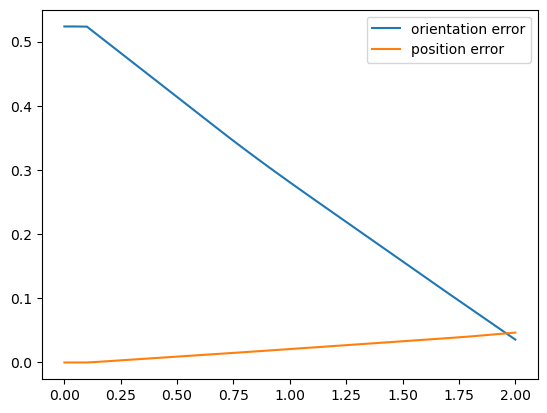

PyObject <matplotlib.legend.Legend object at 0x0000000000F7E390>

In [31]:
# ошибку вычисляем с помощью матриц вращения, потом перевести в angleaxis. Вывести только угол ошибки
ang_errors = zeros(Nt)
pos_errors = zeros(Nt)
r_des = xgoal[1:3]
q_des = xgoal[4:7]
for i in 1:Nt
    x = xtraj[:, i]
    r = x[1:3]
    q = x[4:7]
    err_ang = QuatRotation(q_des) * QuatRotation(q)'
    ang_errors[i] = AngleAxis(QuatRotation(err_ang)).theta
    pos_errors[i] = norm(r-r_des)
end
plot(thist, ang_errors, label="orientation error")
plot(thist, pos_errors, label="position error")
legend()

In [32]:
# траектория с промежуточной точкой
# оживить эйелера

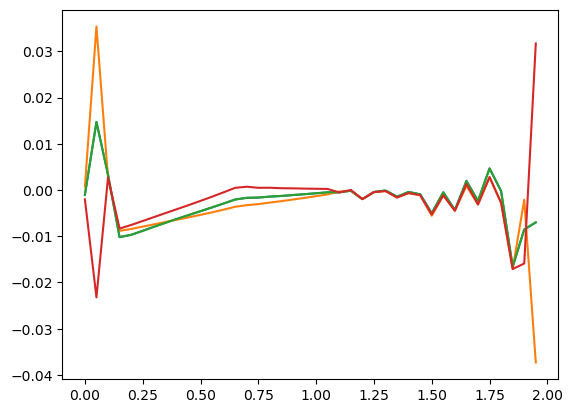

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001960F20>

In [33]:
plot(thist[1:Nt-1],utraj[1,:])
plot(thist[1:Nt-1],utraj[2,:])
plot(thist[1:Nt-1],utraj[3,:])
plot(thist[1:Nt-1],utraj[4,:])

In [34]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8701))

In [35]:
TrajOptPlots.set_mesh!(vis, a)

false

In [36]:
function change_state_form(x)
    out = zeros(13)
    out[1:3] .= x[1:3]
    q = UnitQuaternion(RotXYZ(x[4], x[5], x[6]))
    out[4] = q.w
    out[5] = q.x
    out[6] = q.y
    out[7] = q.z
    out[8:13] .= x[7:12]
    return out
end

change_state_form (generic function with 1 method)

In [37]:
X1 = [SVector{13}(x) for x in eachcol(xtraj)];

visualize!(vis, a, thist[end], X1)

# Feasible angles visualization

In [38]:
# Number of divisions for the sphere
Count = 20

# Generate the sphere mesh
θ = range(0, stop=π, length=Count)
ϕ = range(0, stop=2π, length=Count)
X = [sin(t)*cos(p) for t in θ, p in ϕ]
Y = [sin(t)*sin(p) for t in θ, p in ϕ]
Z = [cos(t) for t in θ, _ in ϕ]

20×20 Matrix{Float64}:
  1.0         1.0         1.0        …   1.0         1.0         1.0
  0.986361    0.986361    0.986361       0.986361    0.986361    0.986361
  0.945817    0.945817    0.945817       0.945817    0.945817    0.945817
  0.879474    0.879474    0.879474       0.879474    0.879474    0.879474
  0.789141    0.789141    0.789141       0.789141    0.789141    0.789141
  0.677282    0.677282    0.677282   …   0.677282    0.677282    0.677282
  0.546948    0.546948    0.546948       0.546948    0.546948    0.546948
  0.401695    0.401695    0.401695       0.401695    0.401695    0.401695
  0.245485    0.245485    0.245485       0.245485    0.245485    0.245485
  0.0825793   0.0825793   0.0825793      0.0825793   0.0825793   0.0825793
 -0.0825793  -0.0825793  -0.0825793  …  -0.0825793  -0.0825793  -0.0825793
 -0.245485   -0.245485   -0.245485      -0.245485   -0.245485   -0.245485
 -0.401695   -0.401695   -0.401695      -0.401695   -0.401695   -0.401695
 -0.546948   -0.54

## iLQR iterations

In [39]:
# ошибку вычисляем с помощью матриц вращения, потом перевести в angleaxis. Вывести только угол ошибки
function calculate_error(last_pos)
    ang_error = 0.0
    pos_error = 0.0
    r_des = xgoal[1:3]
    q_des = xgoal[4:7]
    x = last_pos
    r = x[1:3]
    q = x[4:7]
    err_ang = QuatRotation(q_des) * QuatRotation(q)'
    ang_error = AngleAxis(QuatRotation(err_ang)).theta
    pos_error = norm(r-r_des)
    return ang_error + pos_error
end

calculate_error (generic function with 1 method)

In [40]:
e = [0.0, 0.0, 1.0]
function get_quaternion(n)
        if norm(n) < 1e-8
            next!(bar)
            # print(n)
            return NaN
        end
        n = n / norm(n)
        pitch = cross(e, n)
        if norm(pitch) < 1e-8
            next!(bar)
            # print(n, pitch)
            return NaN
        end
        pitch = pitch / norm(pitch)
        b = cross(pitch, n)
        if norm(b) < 1e-8
            next!(bar)
            # print(n, pitch, b)
            return NaN
        end
        b = b / norm(b)

        T = QuatRotation(RotZYX([n pitch b]))
        # correct inital conditions
        return  [T.w, T.x, T.y, T.z]
end

get_quaternion (generic function with 1 method)

In [41]:
using ProgressMeter
bar = Progress(Count * Count, desc="Iteration: ")
#DDP Algorithm
#Initial Rollout
e = [0.0, 0.0, 1.0]
Hmap_iterations = zeros(Count,Count)
Hmap_time = zeros(Count,Count)
Hmap_error = zeros(Count,Count)
Hmap_cost = zeros(Count, Count)
for i in 1:Count
    for j in 1:Count
        t_start = time()
        iter = 0
        # Tramsform sphere coords to euler angles:
        n = [X[i,j], Y[i,j], Z[i,j]]

        quat = get_quaternion(n)

        if any(isnan, quat)
            # print(quat)
            Hmap_iterations[i,j] = NaN
            Hmap_time[i,j] = NaN
            Hmap_error[i,j] = NaN
            Hmap_cost[i,j] = NaN
            continue
        end
        
        # correct inital conditions
        x0[4:7] .= quat
        # correct initial trajectory
        xtraj = kron(ones(1,Nt), x0)
        utraj = zeros(Nu, Nt-1) .+ uhover
        for k = 1:(Nt-1)
            xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[:,k])
        end
        J = cost(xtraj,utraj)
        # iLQR start
        p = ones(Nx,Nt)
        P = zeros(Nx,Nx,Nt)
        d = ones(Nu,Nt-1)
        K = zeros(Nu,Nx,Nt-1)
        ΔJ = 1.0
        
        xn = zeros(Nx,Nt)
        un = zeros(Nu,Nt-1)
        
        gx = zeros(Nx)
        gu = zeros(Nu)
        Gxx = zeros(Nx,Nx)
        Guu = zeros(Nu)
        Gxu = zeros(Nx)
        Gux = zeros(Nx)
        
        Jp = 0
        stop = false
        while abs(Jp-J) >  5 * 1e-5
            if stop
                break
            end
            iter += 1    
            
            #Backward Pass
            ΔJ = backward_pass!(p,P,d,K)
            if isnan(ΔJ)
                stop = true
                break
            end
            #Forward rollout with line search
            xn[:,1] = xtraj[:,1]
            α = 1.0
            
            # display(K[:,:,1] * (xn[:,1]-xtraj[:,1]))
            # display(utraj[:,1] - α*d[:,1] - K[:,:,1] * (xn[:,1]-xtraj[:,1]))
            
            for k = 1:(Nt-1)
                un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
                try
                    xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
                catch err
                    # print("Current x: $(xn[:,k])\n")
                    # print("Current u: $(un[:,k-1])\n")
                    # print("Previous x: $(xn[:,k-2])\n")
                    stop = true 
                end
            end
            Jn = cost(xn,un)
            # display(Jn)
            while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
                α = 0.5*α
                for k = 1:(Nt-1)
                    un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
                    try
                        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
                    catch err
                        # print("Current x: $(xn[:,k])\n")
                        # print("Current u: $(un[:,k-1])\n")
                        # print("Previous x: $(xn[:,k-2])\n")
                        stop = true
                    end
                end
                Jn = cost(xn,un)
                # display(Jn)
            end
            
            Jp = J
            J = Jn
            xtraj .= xn
            utraj .= un

        end
        if stop
            Hmap_iterations[i,j] = NaN
            Hmap_time[i,j] = NaN
            Hmap_error[i,j] = NaN
            Hmap_cost[i,j] = NaN
        else
            Hmap_iterations[i,j] = iter
            Hmap_time[i,j] = time() - t_start
            Hmap_error[i,j] = calculate_error(xtraj[:, Nt])
            Hmap_cost[i,j] = J
        end
        next!(bar)
    end
end

Iteration: 100%|████████████████████████████████████████| Time: 0:01:30


## Saving obtained iteration heatmap

In [42]:
@save "quaternions/ua/FE/ZOH/full.jld2" Hmap_iterations Hmap_time Hmap_error Hmap_cost
# @save "quaternions/ua/FE/ZOH/iter.jld2" Hmap_iterations
# @save "quaternions/ua/FE/ZOH/time.jld2" Hmap_time
# @save "quaternions/ua/FE/ZOH/error.jld2" Hmap_error
# @save "quaternions/ua/FE/ZOH/cost.jld2" Hmap_cost

## Graph Plotting

In [43]:
@load "quaternions/ua/FE/ZOH/full.jld2" Hmap_iterations Hmap_time Hmap_error Hmap_cost
# @load "quaternions/ua/FE/ZOH/iter.jld2" Hmap_iterations
# @load "quaternions/ua/FE/ZOH/time.jld2" Hmap_time
# @load "quaternions/ua/FE/ZOH/error.jld2" Hmap_error
# @load "quaternions/ua/FE/ZOH/cost.jld2" Hmap_cost

4-element Vector{Symbol}:
 :Hmap_iterations
 :Hmap_time
 :Hmap_error
 :Hmap_cost

In [44]:
# Start the figure
pygui(true)
Hmap_norm = Hmap_error ./ maximum(filter(!isnan, Hmap_error))
fig = PyPlot.figure()
ax = fig.add_subplot(111, projection="3d")
# Custom colormap
cmap = PyPlot.get_cmap("cividis", 256)
cmap.set_bad("red")     # NaNs or masked values
# newcolors = cmap(LinRange(0, 1, 256))
# Red for failing intial conditions
# red = [256/256; 0/256; 0/256; 1]
# newcolors[:1, :] .= red
# newcmp = PyPlot.matplotlib.colors.ListedColormap(newcolors)
colors = cmap.(Hmap_norm)

psm = ax.plot_surface(X, Y, Z,
    facecolors=colors,
    linewidth=0.5, alpha=0.5,
    shade=false)

ax.set_box_aspect([1,1,1])  # Equal aspect ratio
cbar = fig.colorbar(psm, ax=ax)
cbar.set_ticks([0, 1])  # Show ticks at the normalized range
cbar.set_ticklabels([0, maximum(filter(!isnan, Hmap_error))])  # Map ticks back to the original data range
PyPlot.tight_layout()
PyPlot.show()